# Notebook Instructions

1. If you are new to Jupyter notebooks, please go through this introductory manual <a href='https://quantra.quantinsti.com/quantra-notebook' target="_blank">here</a>.
1. Any changes made in this notebook would be lost after you close the browser window. **You can download the notebook to save your work on your PC.**
1. Before running this notebook on your local PC:<br>
i.  You need to set up a Python environment and the relevant packages on your local PC. To do so, go through the section on "**Python Installation**" in the course.<br>
ii. You need to **download the zip file available in the last unit** of this course. The zip file contains the data files and/or python modules that might be required to run this notebook.

# Regression Tree

A regression tree automatically selects important predictors and suggests trading rules. In this notebook, we will learn to create a regression tree using Apple Inc. stock. The predictor variables are one-day returns, five-day returns, five-day standard deviation and so on. The target variable is one-day future return. The tree we create will help us create trading rules for when the future return is expected to be positive or negative.
<BR>

<B>Create a regression tree</B>
1. Import the data
1. Define predictor variables and a target variable
2. Split the data into train and test dataset
3. Create a regression tree model using the train data
4. Visualize the model

<B>Analyzing the performance</B><BR><BR>
Part I: Single leaf
1. Trading rule based on one leaf node with the highest expected value of a target variable
5. Compute performance in the train and test dataset

Part II: Full tree
1. Trading rule based on all the leaf node
5. Compute the performance in the train and test dataset

### Import the data

In [2]:
import pandas as pd
data = pd.read_csv('../data_modules/AAPL_2008_2018.csv', index_col=0)
data.index = pd.to_datetime(data.index)
data.tail(3)

,Open,High,Low,Close,Volume,Dividend,Split,Adj_Open,Adj_High,Adj_Low,Adj_Close,Adj_Volume
Date,,,,,,,,,,,,
2018-04-11,172.23,173.9232,171.70,172.44,22431640.0,0.0,1.0,171.565897,173.252569,171.037941,171.775088,22431640.0
2018-04-12,173.41,175.0000,173.04,174.14,22889285.0,0.0,1.0,172.741347,174.325217,172.372774,173.468533,22889285.0
2018-04-13,174.78,175.8400,173.85,174.73,25124255.0,0.0,1.0,174.106065,175.161978,173.179651,174.056258,25124255.0


### Define predictor variables and a target variable

We define a list of predictors from which the model will pick the best predictors. ret1 is the one-day returns, std5 is the five-day standard deviation and so on. <BR>

<font color='blue'>pct_change()</font> computes the percentage change from the immediately previous row by default and <font color='blue'>dataframe.rolling(window=n).sum( )</font> computes the sum of previous n rows. 

In [3]:
# Returns
data['ret1'] = data.Adj_Close.pct_change()

data['ret5'] = data.ret1.rolling(5).sum()
data['ret10'] = data.ret1.rolling(10).sum()
data['ret20'] = data.ret1.rolling(20).sum()
data['ret40'] = data.ret1.rolling(40).sum()

# Standard Deviation
data['std5'] = data.ret1.rolling(5).std()
data['std10'] = data.ret1.rolling(10).std()
data['std20'] = data.ret1.rolling(20).std()
data['std40'] = data.ret1.rolling(40).std()

We define the target variable which is the future one-day returns of the Apple Inc. stock. <BR>
<font color='blue'>shift(periods=n)</font> shifts the values by n period(s). If the value of n is negative then, it shifts the values backwards and vice-versa.

In [4]:
data['retFut1'] = data.ret1.shift(-1)

We drop the NaN values and store the predictor variables in X and target variable in y.

In [5]:
data = data.dropna()
predictor_list = ['ret1', 'ret5', 'ret10', 'ret20',
                  'ret40', 'std5', 'std10', 'std20', 'std40', 'Volume']
X = data[predictor_list]
y = data.retFut1

### Split the data into train and test dataset
This step is required to verify if the regression tree model we created is any good. We will split the dataset into two parts, first 80% of the dataset will use to create the model and the remaining 20% will be used as a test dataset.

In [6]:
train_length = int(len(data)*0.80)

X_train = X[:train_length]
X_test = X[train_length:]
y_train = y[:train_length]
y_test = y[train_length:]

We have training data in the X_train and y_train for creating the regression tree model and a X_test and y_test to verify the model on unseen data.

### Create regression tree model

We have used DecisionTreeRegressor from sklearn.tree to create the regression tree model. We choose to set min_samples_leaf to 400, but you are free to experiment with other values and see what is optimal on the train dataset. Generally, a leaf size should not be too small to avoid overfitting in the train dataset.

In [7]:
# Regression tree model
from sklearn.tree import DecisionTreeRegressor
dtr = DecisionTreeRegressor(min_samples_leaf=400)

We create the regression tree model using fit() method on the train dataset.

In [8]:
dtr.fit(X_train, y_train)

DecisionTreeRegressor(min_samples_leaf=400)

In [9]:
# Uncomment below line to see details of DecisionTreeRegressor
# help(DecisionTreeRegressor)

### Visualize the model

We now visualize the regression tree created in the below step using the graphviz and sklearn's tree package.

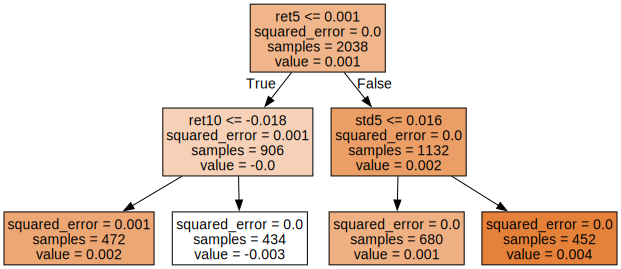

In [10]:
import graphviz
from sklearn import tree
import os

# Uncomment the following line for running on a Windows computer
#os.chdir("C:\\Program Files\\Graphviz\\bin")

dot_data = tree.export_graphviz(dtr,
                                out_file=None,
                                filled=True,
                                feature_names=predictor_list)
graphviz.Source(dot_data)

To practice, create a regression tree model with min_samples_leaf as 100, 500 and 1000 and plot the tree to visualize the difference.

### Trading rule based on the leaf node with the highest target variable value

As seen from the above tree, the right-most child node has the highest value of 0.0037, which can be used to define a long rule. The rule can be paraphrased as when ret5 > 0.0014 (0.14%) and std5 > 0.0157 (0.157%) then buy, else do not buy. So predicted_signal is '1' when buying and '0' otherwise. 

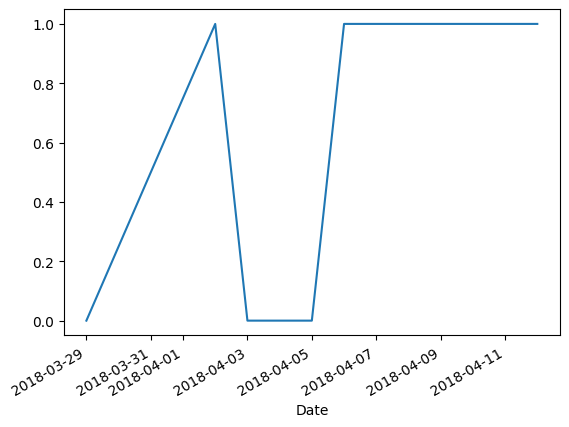

In [10]:
import matplotlib.pyplot as plt
import numpy as np
data['predicted_signal'] = np.where(
    ((data.ret5 > 0.0014) & (data.std5 > 0.0155)), 1, 0)

# Visualizing the signal predicted for last 10 days

data.predicted_signal[-10:].plot()
plt.show()

The above graph shows the signal predicted for last 10 days. The strategy returns are generated by multiplying the future returns by the predicted signal and stored in the strategy_returns.

In [11]:
data['strategy_returns_single_leaf'] = data.retFut1 * data.predicted_signal

### Trading rule based on the full tree

We define a trading rule based on the expected response of every single leaf. If the expected value is positive then we buy the Apple Inc. stock and otherwise, we sell the stock.

In [12]:
data['predicted_signal'] = np.where(dtr.predict(X) > 0, 1, -1)
data['strategy_returns_full_tree'] = data.retFut1 * data.predicted_signal

### Save the File on Your Disk

We will store the close and predicted signal of the test dataset in a CSV file which will be used in next notebook for further trade level analysis.

Syntax:
```python
DataFrame.to_csv(file_name)
```

The above line will save `DataFrame` as a CSV file with the name `file_name` on your local disk.

<b> The following cell will not run in the browser. Download this notebook and convert the cell to "Code" type.</b>

### Performance computation for single leaf

Sharpe Ratio

The Sharpe ratio is calculated as follows:

<img src="https://d2a032ejo53cab.cloudfront.net/Glossary/R2TAJa6K/Sharpe-1.jpg"></img>

Where
- N is the number of trading days in a year
- Rf is the risk-free rate
- Std dev is the standard deviation

Sharpe ratio represents how good the strategy performance is for the risk (standard deviation) taken to achieve it. The higher the Sharpe ratio the better is the strategy. Generally, a Sharpe ratio of greater than 1.5 is preferred.

In [13]:
# The below function returns the Sharpe ratio for the excess returns (Strategy returns - Risk free rate) passed to it.
def annualized_sharpe_ratio(returns, N=252):
    return np.sqrt(N) * returns.mean() / returns.std()

We calculate the Sharpe ratio for the strategy in train and test dataset. The risk-free rate is assumed to be 5% p.a.

In [14]:
# Sharpe ratio
# Train dataset
data['excess_daily_strategy_return'] = data.strategy_returns_single_leaf - 0.05/252

sharpe_train_single_leaf = annualized_sharpe_ratio(
    data.excess_daily_strategy_return.iloc[:train_length])

# Test dataset
sharpe_test_single_leaf = annualized_sharpe_ratio(
    data.excess_daily_strategy_return.iloc[train_length:])

### Strategy CAGR
CAGR represents the compounded annual returns of the strategy. The strategy CAGR is computed as follows:

<i>(Cumulative returns + 1)^(252/number of days) - 1</i>

where cumulative returns are the total strategy returns and the number of days represent the total trading days.

In [15]:
def CAGR(returns):
    cumulative_returns = returns.cumsum().iloc[-1]
    period_in_days = len(returns)
    return 100*((cumulative_returns+1)**(252.0/period_in_days)-1)

In [16]:
# Single Leaf
# Train dataset
ret_train_single_leaf = CAGR(
    data.strategy_returns_single_leaf.iloc[:train_length])
# Test dataset
ret_test_single_leaf = CAGR(
    data.strategy_returns_single_leaf.iloc[train_length:])

### Performance computation for full tree

In [17]:
# Calculate Sharpe ratio

# Train dataset
data['excess_daily_strategy_return'] = data.strategy_returns_full_tree - 0.05/252
sharpe_train_full_tree = annualized_sharpe_ratio(
    data.excess_daily_strategy_return.iloc[:train_length])

# Test dataset
sharpe_test_full_tree = annualized_sharpe_ratio(
    data.excess_daily_strategy_return.iloc[train_length:])

In [18]:
# Calculate CAGR

# Train dataset
ret_train_full_tree = CAGR(data.strategy_returns_full_tree.iloc[:train_length])

# Test dataset
ret_test_full_tree = CAGR(data.strategy_returns_full_tree.iloc[train_length:])

### Performance Comparision of single leaf and full tree

Cumulative returns in train dataset.

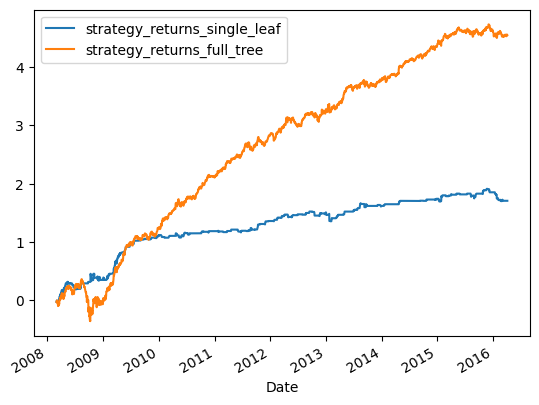

In [19]:
# Plot the cumulative returns for single leaf in train dataset
data.strategy_returns_single_leaf[:train_length].cumsum().plot()

# Plot the cumulative returns for full tree in train dataset
data.strategy_returns_full_tree[:train_length].cumsum().plot()

# Show the legend
plt.legend()

# Show the graph
plt.show()

Cumulative returns in the test dataset.

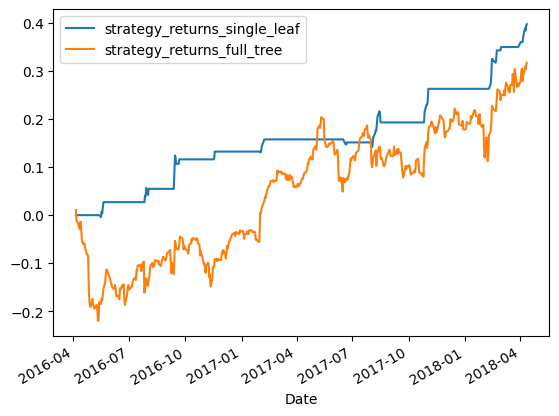

In [20]:
# Plot the cumulative returns for single leaf in train dataset
data.strategy_returns_single_leaf[train_length:].cumsum().plot()

# Plot the cumulative returns for full tree in train dataset
data.strategy_returns_full_tree[train_length:].cumsum().plot()

# Show the legend
plt.legend()

# Show the graph
plt.show()

In [21]:
from tabulate import tabulate

# Tabulate the performance in train and test dataset for single leaf and a full tree
print(tabulate(
    [
        ['CAGR', ret_train_single_leaf, ret_train_full_tree,
         ret_test_single_leaf, ret_test_full_tree],
        ['Sharpe Ratio', sharpe_train_single_leaf, sharpe_train_full_tree,
         sharpe_test_single_leaf, sharpe_test_full_tree],
    ],
    headers=['Train (Single Leaf)', 'Train (Full Tree)',
             'Test (Single Leaf)',  'Test (Full Tree)'],
    tablefmt='orgtbl'))

|              |   Train (Single Leaf) |   Train (Full Tree) |   Test (Single Leaf) |   Test (Full Tree) |
|--------------+-----------------------+---------------------+----------------------+--------------------|
| CAGR         |             13.1046   |             23.601  |             17.9598  |          14.5425   |
| Sharpe Ratio |              0.963454 |              1.5827 |              2.10255 |           0.525311 |


 In the next section, we will explore some ensemble techniques for reducing overfitting so that we can, in fact, use all leaves for prediction.
<BR>